In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")


In [33]:
import pandas as pd

df = pd.read_csv(
    "D:/Study/PROJECTS/energy-forecasting/data/household_power_consumption.txt",
    sep=';',
    low_memory=False,
    na_values=['?']
)


df['datetime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    dayfirst=True
)

df.set_index('datetime', inplace=True)


df = df[['Global_active_power']]

# Drop missing values
df.dropna(inplace=True)

df.head()


,Global_active_power
datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [34]:
daily_df = df.resample('D').mean()
daily_df.head()


,Global_active_power
datetime,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658


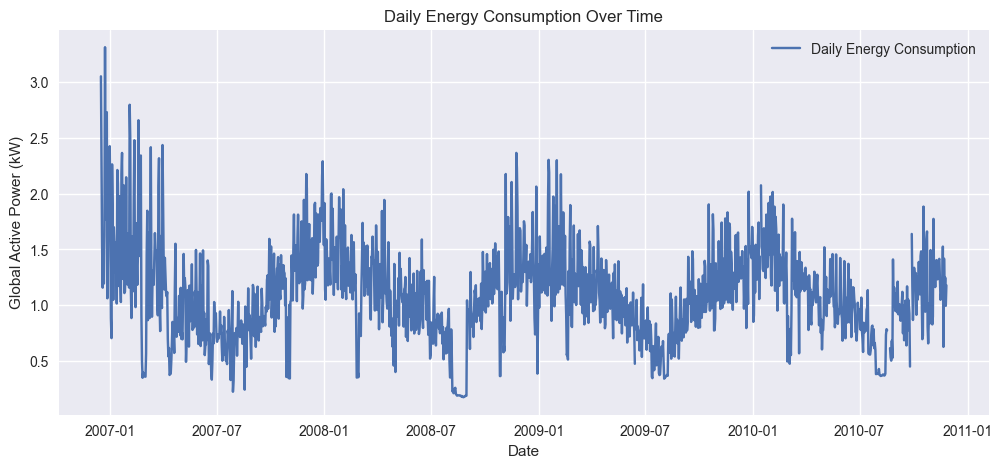

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(daily_df, label="Daily Energy Consumption")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.title("Daily Energy Consumption Over Time")
plt.legend()
plt.show()


In [36]:
train = daily_df.iloc[:-365]
test = daily_df.iloc[-365:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (1077, 1)
Test shape: (365, 1)


### Stationarity Note

The Augmented Dickey–Fuller (ADF) test was attempted as a diagnostic step.
For modeling, ARIMA with first-order differencing (`d=1`) was used to
handle non-stationarity directly.


In [37]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()

print(arima_result.summary())


                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 1077
Model:                  ARIMA(1, 1, 1)   Log Likelihood                -316.280
Date:                 Thu, 18 Dec 2025   AIC                            638.560
Time:                         20:10:20   BIC                            653.503
Sample:                     12-16-2006   HQIC                           644.220
                          - 11-26-2009                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2396      0.028      8.544      0.000       0.185       0.295
ma.L1         -0.8851      0.016    -55.383      0.000      -0.916      -0.854
sigma2         0.1054      0.004     29.815 

In [38]:

arima_forecast = arima_result.forecast(steps=len(test))
y_pred = np.asarray(arima_forecast)


In [39]:

test_clean = test.dropna()

# Align forecast with cleaned test
y_true = test_clean['Global_active_power'].values
y_pred = y_pred[:len(y_true)]

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_arima = mean_absolute_error(y_true, y_pred)
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred))

print("ARIMA MAE:", mae_arima)
print("ARIMA RMSE:", rmse_arima)


ARIMA MAE: 0.3329187724807834
ARIMA RMSE: 0.41370642937443364


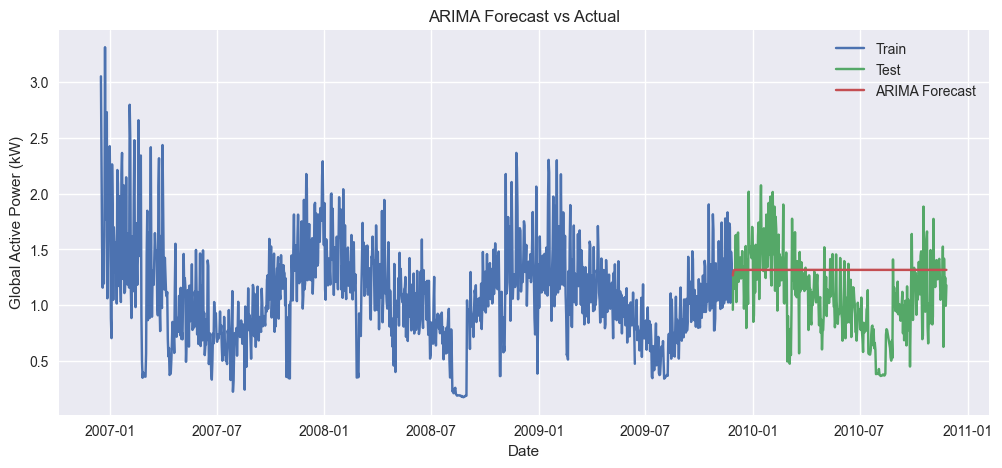

In [40]:
plt.figure(figsize=(12,5))


plt.plot(
    train.index,
    train['Global_active_power'],
    label="Train"
)


plt.plot(
    test_clean.index,
    y_true,
    label="Test"
)


plt.plot(
    test_clean.index,
    y_pred,
    label="ARIMA Forecast"
)

plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()


In [41]:
def create_lag_features(data, lags=[1, 7, 14]):
    df_feat = data.copy()
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat['Global_active_power'].shift(lag)
    return df_feat.dropna()

feat_df = create_lag_features(daily_df)
feat_df.head()


,Global_active_power,lag_1,lag_7,lag_14
datetime,,,,
2006-12-30,1.939709,2.204439,3.314851,3.053475
2006-12-31,2.426525,1.939709,1.770842,2.354486
2007-01-01,1.909031,2.426525,1.904944,1.530435
2007-01-02,0.881414,1.909031,2.732021,1.157079
2007-01-03,0.704204,0.881414,1.061639,1.545658


In [42]:
train_feat = feat_df.iloc[:-365]
test_feat = feat_df.iloc[-365:]

X_train = train_feat.drop('Global_active_power', axis=1)
y_train = train_feat['Global_active_power']

X_test = test_feat.drop('Global_active_power', axis=1)
y_test = test_feat['Global_active_power']

print(X_train.shape, X_test.shape)


(1031, 3) (365, 3)


In [44]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

xgb_pred = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))

print("XGBoost MAE:", mae_xgb)
print("XGBoost RMSE:", rmse_xgb)


XGBoost MAE: 0.19728196160675834
XGBoost RMSE: 0.2656237425854224


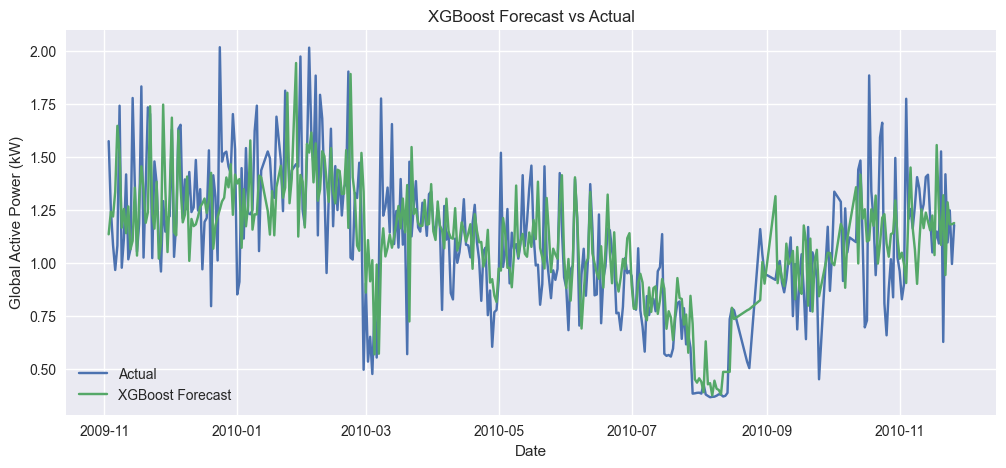

In [46]:
plt.figure(figsize=(12,5))
plt.plot(test_feat.index, y_test.values, label="Actual")
plt.plot(test_feat.index, xgb_pred, label="XGBoost Forecast")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.title("XGBoost Forecast vs Actual")
plt.legend()
plt.show()


In [47]:
comparison_df = pd.DataFrame({
    "Model": ["ARIMA", "XGBoost"],
    "MAE": [mae_arima, mae_xgb],
    "RMSE": [rmse_arima, rmse_xgb]
})

comparison_df


,Model,MAE,RMSE
0,ARIMA,0.332919,0.413706
1,XGBoost,0.197282,0.265624


## Model Comparison & Conclusion

- ARIMA was used as a statistical baseline and provides a stable forecast by capturing overall trend.
- XGBoost, using lag-based feature engineering, captures non-linear patterns and short-term variations more effectively.
- The comparison highlights trade-offs between classical time-series models and feature-based machine learning approaches.
